## I. Load dữ liệu giá nhà

In [1]:
import numpy as np 
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
def load_data(file_name):
    dat = pd.read_csv(file_name)
    N = dat.shape[0]

    yrs_old = np.zeros(N)
    yrs_reno = np.zeros(N)
    for i in range(N):
        year_sell = int(dat['date'][i][-4:])
        yrs_old[i] = year_sell - dat['yr_built'][i]
        if dat['yr_renovated'][i] == 0:
            yrs_reno[i] = 0
        else:
            yrs_reno[i] = year_sell - dat['yr_renovated'][i]

    y = np.array(dat['price']).reshape((N, 1)) * 10e-6

    yrs_old = yrs_old.reshape((N, 1))
    yrs_reno = yrs_reno.reshape((N, 1))
    X = dat.to_numpy(dat.drop(columns=['id', 'date', 'price', 'yr_built', \
                                       'yr_renovated'], inplace=True)) # 'zipcode', 'lat', 'long
    X = np.concatenate((X, yrs_old, yrs_reno), axis=1)
    X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

    return X, y

In [3]:
X, y = load_data('kc_house_data.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17277, 18)
(17277, 1)
(4320, 18)
(4320, 1)


## III. Các hàm và thư viện cần thiết

In [6]:
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt

In [7]:
def draw_cost_curve(model):
    cost_t_values = model.cost_t_values
    cost_v_values = model.cost_v_values
    plt.plot(cost_t_values)
    plt.plot(cost_v_values)
    plt.show()

In [8]:
def conclusion(model, score=None):
    if score is None: score = model.score
    print("===================")
    print("R^2 score on the training set: ", score(X_train, y_train))
    print("R^2 score on the testing set: ", score(X_test, y_test))
    print("Time for fitting: ", model.fitting_time)
    if model.benchmark_enabled:
        print("Cost on the training set: ", model.cost_t_values[-1])
        print("Cost on the testing set: ", model.cost_v_values[-1])
        draw_cost_curve(model)

## IV. Sử dụng phương pháp tối ưu & mô hình Hồi quy tuyến tính từ thư viện Scikit-learn:

In [9]:
from sklearn.linear_model import LinearRegression as SKLinearRegression

In [10]:
model = SKLinearRegression(n_jobs=2)
model.fit(X_train,y_train)

LinearRegression(n_jobs=2)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MSE : ",mean_squared_error(y_pred , y_test))
print("Score : ",r2_score(y_test, y_pred))

MSE :  4.020539317290363
Score :  0.6912414243603853


## V. Tự xây dựng các thuật toán tối ưu Gradient Descent, Stochastic Gradient Descent và Mini Batch Gradient Descent cho mô hình Linear Regression

### Linear Regression

In [12]:
class LinearRegression:
    def __init__(self, optimizer, step_size, steps=100, benchmark_enabled=True, 
                 alpha=0.5, beta=0.5, backtracking_enabled=False, tol=10e-4, early_stopping_enabled=False):
        self.optimizer = optimizer
        self.step_size = step_size
        self.steps = steps
        self.params = None
        self.cost_t_values = list()
        self.cost_v_values = list()
        self.fitting_time = None
        self.benchmark_enabled = benchmark_enabled
        self.alpha = alpha
        self.beta = beta
        self.backtracking_enabled = backtracking_enabled
        self.early_stopping_enabled = early_stopping_enabled
        self.tol = tol
        
    def fit(self, X_train, y_train, X_test, y_test):
        start_time = time.time()
        X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
        X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
        self.params = self.optimizer(X_train, y_train, X_test, y_test, self)
        self.fitting_time = time.time() - start_time
        
    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        y_pred = np.dot(X, self.params)
        return y_pred
    
    @staticmethod
    def gradient(X, y_pred, y):
        N = y.shape[0]
        return 2 / N * np.dot(X.transpose(),(y_pred - y))
    
    @staticmethod
    def hessian(X):
        N = X.shape[0]
        return np.squeeze(2 / N * np.dot(X.transpose(), X))[()]
    
    @staticmethod
    def cost(y, y_pred):
        N = y.shape[0]
        residual = y - y_pred
        return 1/N * np.squeeze(np.dot(residual.transpose(), residual))[()]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        residual = y - y_pred
        rss = np.squeeze(np.dot(residual.transpose(), residual))[()]
        y_mean = np.expand_dims(np.mean(y) * np.ones(y.shape[0]), axis=1)
        total = y - y_mean
        tss = np.squeeze(np.dot(total.transpose() , total))[()]
        r_score = 1 - rss/tss
        return r_score

### Gradient Descent

In [36]:
def gradient_descent(X_train, y_train, X_test, y_test, m):
    gradient, cost, cost_t_values, cost_v_values = m.gradient, m.cost, m.cost_t_values, m.cost_v_values
    alpha, beta = m.alpha, m.beta
    params = np.ones((X_train.shape[1], 1))
    cost_t_value = cost(y_train, np.dot(X_train, params))
    step_numb = 0
    max_step_inside = 10
    while step_numb < m.steps:
        step_size = m.step_size
        y_pred = np.dot(X_train, params)
        if m.benchmark_enabled:
            prev_cost = cost_t_value
            
        grad = gradient(X_train, y_pred, y_train)
        params -= step_size * grad
        if m.benchmark_enabled or m.backtracking_enabled:
            cost_t_value = cost(y_train, y_pred)
            cost_t_values.append(cost_t_value)
            cost_v_value = cost(y_test, np.dot(X_test, params))
            cost_v_values.append(cost_v_value)
    
        # Backtracking to shrink step_size
        if m.backtracking_enabled:
            grad_norm = np.linalg.norm(grad)
            margin = alpha * step_size * grad_norm**2
            step_inside = 0
            while cost_t_value > prev_cost - margin:
                step_size *= beta
                margin = alpha * step_size * grad_norm**2
                step_inside += 1
                if step_inside > max_step_inside: break
        params -= step_size * grad
        if m.early_stopping_enabled and np.max(np.absolute(grad)) < m.tol: 
            break
        step_numb += 1
        
    print("Total steps: ", step_numb)
    print("Max abs component of grad: ", np.max(np.absolute(grad)))
    return params

In [37]:
# best with step size: 11, steps: 150
lreg_with_gd = LinearRegression(gradient_descent, 10e-2, 20000, benchmark_enabled=True, backtracking_enabled=True, tol=10e-4, early_stopping_enabled=True)
lreg_with_gd.fit(X_train,y_train, X_test, y_test)

Total steps:  14272
Max abs component of grad:  0.0009998877585877999


R^2 score on the training set:  0.7018678497369641
R^2 score on the testing set:  0.6915378218930572
Time for fitting:  9.67751693725586
Cost on the training set:  4.058474446819878
Cost on the testing set:  4.016679454890366


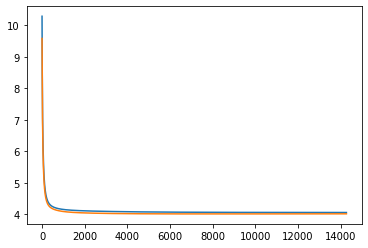

In [38]:
conclusion(lreg_with_gd)

### Accelerated gradient

### Newton

In [16]:
# def newton(X_train, y_train, X_test, y_test, m):
#     gradient, cost, cost_t_values, cost_v_values = m.gradient, m.cost, m.cost_t_values, m.cost_v_values
#     alpha, beta = m.alpha, m.beta
#     params = np.ones((X_train.shape[1], 1))
#     cost_t_value = cost(y_train, np.dot(X_train, params))
#     step_numb = 0
#     max_step_inside = 10
#     hess = m.hessian(X_train)
#     inv_hess = np.linalg.inv(hess)
#     while step_numb < m.steps:
#         y_pred = np.dot(X_train, params)
#         if m.benchmark_enabled:
#             prev_cost = cost_t_value
#         grad = gradient(X_train, y_pred, y_train)
#         params -= np.dot(inv_hess , grad)
#         if m.benchmark_enabled or m.backtracking_enabled:
#             cost_t_value = cost(y_train, y_pred)
#             cost_t_values.append(cost_t_value)
#             cost_v_value = cost(y_test, np.dot(X_test, params))
#             cost_v_values.append(cost_v_value)

#         if m.early_stopping_enabled and np.max(np.absolute(grad)) < m.tol: 
#             break
#         step_numb += 1
        
#     print("Total steps: ", step_numb)
#     print("Max abs component of grad: ", np.max(np.absolute(grad)))
#     return params

In [17]:
# # best with step size: 5
# lreg_with_newton = LinearRegression(newton, 10e-2, 20000, benchmark_enabled=True, backtracking_enabled=False, tol=10e-4, early_stopping_enabled=True)
# lreg_with_newton.fit(X_train,y_train, X_test, y_test)

Total steps:  10
Max abs component of grad:  9.792487623507279e-05


R^2 score on the training set:  0.7019257176447629
R^2 score on the testing set:  0.691241219237282
Time for fitting:  0.016505718231201172
Cost on the training set:  4.057686553774348
Cost on the testing set:  4.020541988327116


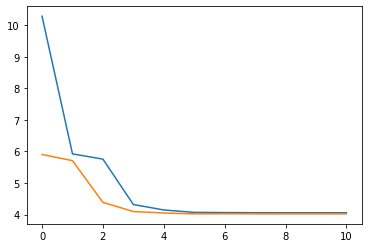

In [18]:
# conclusion(lreg_with_newton)

In [44]:
def newton(X_train, y_train, X_test, y_test, m):
    gradient, cost, cost_t_values, cost_v_values = m.gradient, m.cost, m.cost_t_values, m.cost_v_values
    alpha, beta = m.alpha, m.beta
    params = np.ones((X_train.shape[1], 1))
    cost_t_value = cost(y_train, np.dot(X_train, params))
    step_numb = 0
    max_step_inside = 10
    hess = m.hessian(X_train)
    inv_hess = np.linalg.inv(hess)
    while step_numb < m.steps:
        t = m.step_size
        y_pred = np.dot(X_train, params)
        if m.benchmark_enabled:
            prev_cost = cost_t_value
        grad = gradient(X_train, y_pred, y_train)

        if m.benchmark_enabled or m.backtracking_enabled:
            cost_t_value = cost(y_train, y_pred)
            cost_t_values.append(cost_t_value)
            cost_v_value = cost(y_test, np.dot(X_test, params))
            cost_v_values.append(cost_v_value)
    
        # Backtracking to shrink step_size
        if m.backtracking_enabled:
            v = -inv_hess.dot(grad)
            t = 1
            margin = alpha * t * np.dot(grad.transpose() , v)
            step_inside = 0
            while cost_t_value > prev_cost - margin:
                t *= beta
                margin = alpha * t * np.dot(grad.transpose() , v)
                step_inside += 1
                if step_inside > max_step_inside: break
        params -= t * np.dot(inv_hess , grad)
        if m.early_stopping_enabled and np.max(np.absolute(grad)) < m.tol: 
            break
        step_numb += 1
    if m.early_stopping_enabled:
        print("Total steps: ", step_numb)
        print("Max abs component of grad: ", np.max(np.absolute(grad)))
    return params

In [49]:
lreg_with_newton = LinearRegression(newton, 10e-2, 1000, benchmark_enabled=True, backtracking_enabled=False, tol=10e-6, early_stopping_enabled=False)
lreg_with_newton.fit(X_train,y_train, X_test, y_test)

Total steps:  1000
Max abs component of grad:  7.709472992345256e-15


R^2 score on the training set:  0.70192571794554
R^2 score on the testing set:  0.691241195511456
Time for fitting:  0.8177528381347656
Cost on the training set:  4.057686441827483
Cost on the testing set:  4.020542297275997


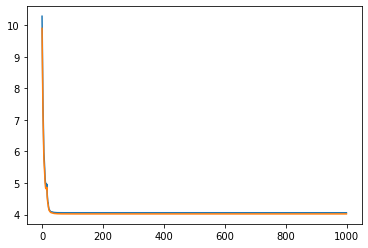

In [50]:
conclusion(lreg_with_newton)

## VI. So sánh các thuật toán

### So sánh tốc độ giảm loss theo số steps

In [ ]:
step_size = 1000
step = 10e-2
lreg_with_gd = LinearRegression(gradient_descent, step, step_size, benchmark_enabled=True, backtracking_enabled=False, tol=10e-4, early_stopping_enabled=False)
lreg_with_gd.fit(X_train,y_train, X_test, y_test)

lreg_with_newton = LinearRegression(newton, step, step_size, benchmark_enabled=True, backtracking_enabled=False, tol=10e-6, early_stopping_enabled=False)
lreg_with_newton.fit(X_train,y_train, X_test, y_test)

def draw_cost_curves():
    plt.plot(lreg_with_gd.cost_v_values)
    plt.plot(lreg_with_newton.cost_v_values)
    plt.show()
draw_cost_curves()

### So sánh tốc độ thực thi sau khi loss giảm đến 1 ngưỡng cố định:

In [52]:
step_size = 20000
step = 10e-2
tol=10e-6
early_stopping_enabled = True
lreg_with_gd = LinearRegression(gradient_descent, step, step_size, benchmark_enabled=True, backtracking_enabled=False, tol=tol, early_stopping_enabled=early_stopping_enabled)
lreg_with_gd.fit(X_train,y_train, X_test, y_test)

lreg_with_newton = LinearRegression(newton, step, step_size, benchmark_enabled=True, backtracking_enabled=False, tol=tol, early_stopping_enabled=early_stopping_enabled)
lreg_with_newton.fit(X_train,y_train, X_test, y_test)

def draw_time_bar():
    optimizers = ["GD", "Accelerated GD", "Newton"]
    values = [lreg_with_gd.fitting_time, 0, lreg_with_newton.fitting_time]
    fig = plt.figure(figsize = (10, 5))
    plt.bar(optimizers, values, color ='maroon',
            width = 0.4)
    plt.ylabel("Time (in seconds)")
    plt.show()
draw_time_bar()

Total steps:  20000
Max abs component of grad:  0.00035880039854184633
Total steps:  175
Max abs component of grad:  9.428991769799098e-06


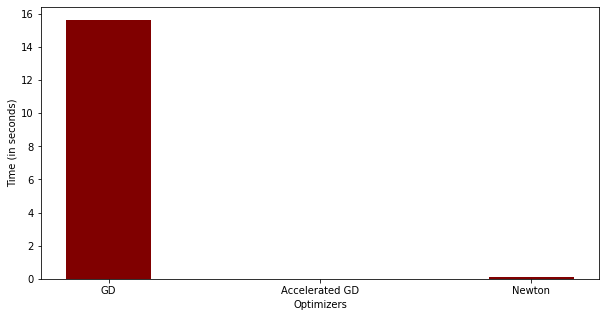